In [46]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import logging
import seaborn as sns
from pathlib import Path
logging.getLogger('matplotlib.font_manager').disabled = True
import os
import numpy as np

In [38]:
data_type = 'hourly_avg_clustering'

In [39]:
key_path = "/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/Survey_Data/00_SWW_ID_smartmeter.xlsx"
key_df = pd.read_excel(key_path, header=None)

# Load the Excel file
file_path = "/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/Survey_Data/Survey_Data.xlsx"
# Read without headers, so columns are numbered 0,1,2,...
df = pd.read_excel(file_path, skiprows=4, nrows=1500, header=None)

# Now columns 10 and 131 correspond to Excel columns K and Q exactly (0-based)
cols_to_extract = [10, 142, 143, 145, 146, 148, 153, 154, 155, 156]
extracted_df = df.iloc[:, cols_to_extract]

# Assign your own headers
extracted_df.columns = ['house-id', 'building type', 'solar panels', 'electric vehicle', 
                        'electric water heating', 'days at home', 'DR heating', 'DR hot water', 'DR EV', 'DR appliances']

extracted_df_pl = pl.from_pandas(extracted_df)

total_rows = extracted_df_pl.height

# Count unique house_id values
unique_house_ids = extracted_df_pl["house-id"].n_unique()

print(f"Total rows: {total_rows}")
print(f"Unique house-id count: {unique_house_ids}")

if total_rows > unique_house_ids:
    print(f"There are {total_rows - unique_house_ids} duplicate house_id entries.")
else:
    print("No duplicates found in house_id column.")

#print(extracted_df)

# Save extracted columns to a new Excel or CSV file if needed

#extracted_df.to_csv("extracted_columns.csv", index=False)

Total rows: 1500
Unique house-id count: 1500
No duplicates found in house_id column.


In [40]:

# Column 1 (index 0) has original house IDs, column 2 (index 1) has CH... identifiers
# Create a mapping dict: {house_id: CH_id}
mapping = dict(zip(key_df.iloc[:,0], key_df.iloc[:,2]))

# Map 'house-id' in extracted_df to 'CH...' values
# Safely assign new column using .loc to avoid SettingWithCopyWarning
extracted_df = extracted_df.copy()
extracted_df['CH_id'] = extracted_df['house-id'].map(mapping)

#print(extracted_df)


In [41]:
result_df = pl.read_csv(f'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/{data_type}.csv')

# Read the alle_mittelwerte file
alle_mittelwerte_df = pl.read_csv("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/alle_mittelwerte.csv") 

# Normalize keys in all DataFrames for clean join
result_df = result_df.with_columns(
    pl.col("house_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

alle_mittelwerte_df = alle_mittelwerte_df.with_columns(
    pl.col("file_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

result_df = result_df.join(
    alle_mittelwerte_df.select([
        "ch_id_clean",
        "bruttolastgang_kwh_sum",
        "average_daily_consumption"
    ]),
    on="ch_id_clean",
    how="left"
)
result_df = result_df.select([
    "house_id",
    "cluster",
    "bruttolastgang_kwh_sum",
    "average_daily_consumption"  
])

cluster_summary = result_df.group_by("cluster").agg([
    pl.count("house_id").alias("num_households"),
    pl.mean("bruttolastgang_kwh_sum").alias("avg_total_consumption [kWh]").round(2),
    pl.mean("average_daily_consumption").alias("avg_daily_consumption [kWh]").round(2)
]).sort("cluster")

print(cluster_summary)

shape: (4, 4)
┌─────────┬────────────────┬─────────────────────────────┬─────────────────────────────┐
│ cluster ┆ num_households ┆ avg_total_consumption [kWh] ┆ avg_daily_consumption [kWh] │
│ ---     ┆ ---            ┆ ---                         ┆ ---                         │
│ i64     ┆ u32            ┆ f64                         ┆ f64                         │
╞═════════╪════════════════╪═════════════════════════════╪═════════════════════════════╡
│ 1       ┆ 467            ┆ 4947.07                     ┆ 8.61                        │
│ 2       ┆ 665            ┆ 2968.74                     ┆ 5.06                        │
│ 3       ┆ 184            ┆ 8418.89                     ┆ 13.03                       │
│ 4       ┆ 165            ┆ 7295.63                     ┆ 12.18                       │
└─────────┴────────────────┴─────────────────────────────┴─────────────────────────────┘


In [42]:
extracted_pl_df = pl.from_pandas(extracted_df)

print(extracted_pl_df.shape)

# Read the alle_mittelwerte file
alle_mittelwerte_df = pl.read_csv("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/alle_mittelwerte.csv")  # Adjust path as needed

# Normalize keys in all DataFrames for clean join
# Normalize keys
result_df = result_df.with_columns(
    pl.col("house_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

extracted_pl_df = extracted_pl_df.with_columns(
    pl.col("CH_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

alle_mittelwerte_df = alle_mittelwerte_df.with_columns(
    pl.col("file_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

# First join: attach survey columns
joined = result_df.join(
    extracted_pl_df.select([
        "ch_id_clean",
        "building type",
        "solar panels",
        "electric vehicle",
        "electric water heating",
        "days at home",
        "DR heating",
        "DR hot water",
        "DR EV",
        "DR appliances"
    ]),
    on="ch_id_clean",
    how="left"
)

# Second join: attach consumption
joined = joined.join(
    alle_mittelwerte_df.select(["ch_id_clean", "bruttolastgang_kwh_sum"]),
    on="ch_id_clean",
    how="left"
)

# Now select in the desired order
final_df = joined.select([
    "house_id",                # Column 0
    "bruttolastgang_kwh_sum",  # Column 1
    "cluster",                 # Column 2
    "building type",
    "solar panels",
    "electric vehicle",
    "electric water heating",
    "days at home",
    "DR heating",
    "DR hot water",
    "DR EV",
    "DR appliances"
])

print(final_df.head())

(1500, 11)
shape: (5, 12)
┌────────────┬───────────┬─────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ house_id   ┆ bruttolas ┆ cluster ┆ building  ┆ … ┆ DR        ┆ DR hot    ┆ DR EV     ┆ DR applia │
│ ---        ┆ tgang_kwh ┆ ---     ┆ type      ┆   ┆ heating   ┆ water     ┆ ---       ┆ nces      │
│ str        ┆ _sum      ┆ i64     ┆ ---       ┆   ┆ ---       ┆ ---       ┆ str       ┆ ---       │
│            ┆ ---       ┆         ┆ str       ┆   ┆ str       ┆ str       ┆           ┆ str       │
│            ┆ f64       ┆         ┆           ┆   ┆           ┆           ┆           ┆           │
╞════════════╪═══════════╪═════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ CH10186012 ┆ 1116.376  ┆ 1       ┆ Flat      ┆ … ┆ yes       ┆ yes       ┆ No Inform ┆ yes       │
│ 3450000000 ┆           ┆         ┆           ┆   ┆           ┆           ┆ ation     ┆           │
│ 0000000112 ┆           ┆         ┆           ┆   ┆           ┆ 

In [43]:
def categorize_consumption(value):
    if value < 5000:
        return "0-5 MWh"
    elif value < 10000:
        return "5-10 MWh"
    elif value < 15000:
        return "10-15 MWh"
    elif value < 20000:
        return "15-20 MWh"
    elif value < 25000:
        return "20-25 MWh"
    else:
        return "25+ MWh"

final_df = final_df.with_columns(
    pl.col("bruttolastgang_kwh_sum")
      .map_elements(categorize_consumption, return_dtype=pl.Utf8)
      .alias("consumption_category")
)

print(final_df.head())

final_df.write_csv("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/hourly_avg_clustering_category.csv")

print(final_df.shape)


shape: (5, 13)
┌────────────┬───────────┬─────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ house_id   ┆ bruttolas ┆ cluster ┆ building  ┆ … ┆ DR hot    ┆ DR EV     ┆ DR applia ┆ consumpti │
│ ---        ┆ tgang_kwh ┆ ---     ┆ type      ┆   ┆ water     ┆ ---       ┆ nces      ┆ on_catego │
│ str        ┆ _sum      ┆ i64     ┆ ---       ┆   ┆ ---       ┆ str       ┆ ---       ┆ ry        │
│            ┆ ---       ┆         ┆ str       ┆   ┆ str       ┆           ┆ str       ┆ ---       │
│            ┆ f64       ┆         ┆           ┆   ┆           ┆           ┆           ┆ str       │
╞════════════╪═══════════╪═════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ CH10186012 ┆ 1116.376  ┆ 1       ┆ Flat      ┆ … ┆ yes       ┆ No Inform ┆ yes       ┆ 0-5 MWh   │
│ 3450000000 ┆           ┆         ┆           ┆   ┆           ┆ ation     ┆           ┆           │
│ 0000000112 ┆           ┆         ┆           ┆   ┆           ┆           ┆

In [44]:
count = final_df.filter(
    (pl.col('bruttolastgang_kwh_sum') > 30000) &
    (pl.col('electric vehicle') == 'yes')
).height

print(count)

count = final_df.filter(
    (pl.col('bruttolastgang_kwh_sum') > 30000)
).height

print(count)

6
9


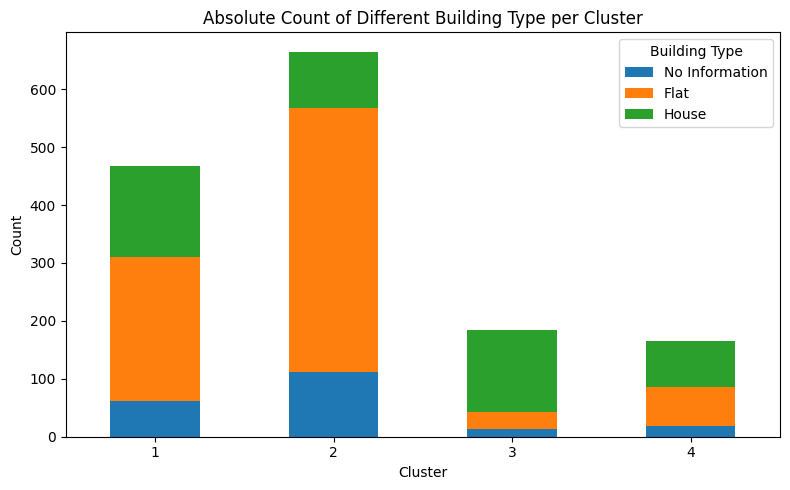

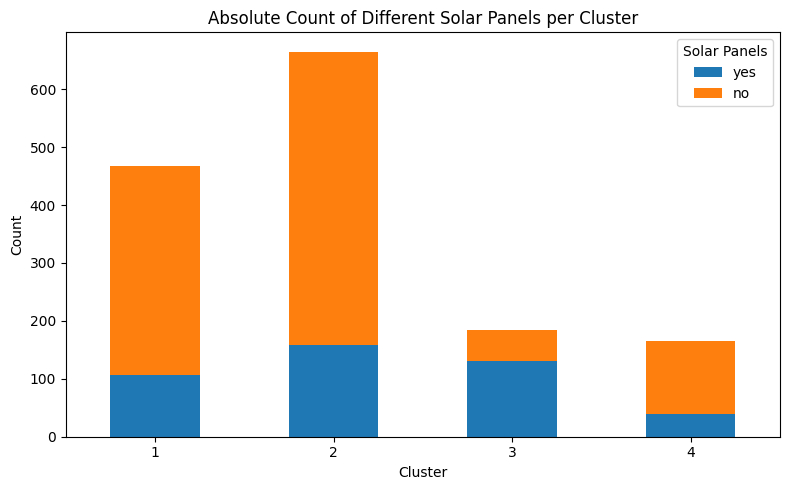

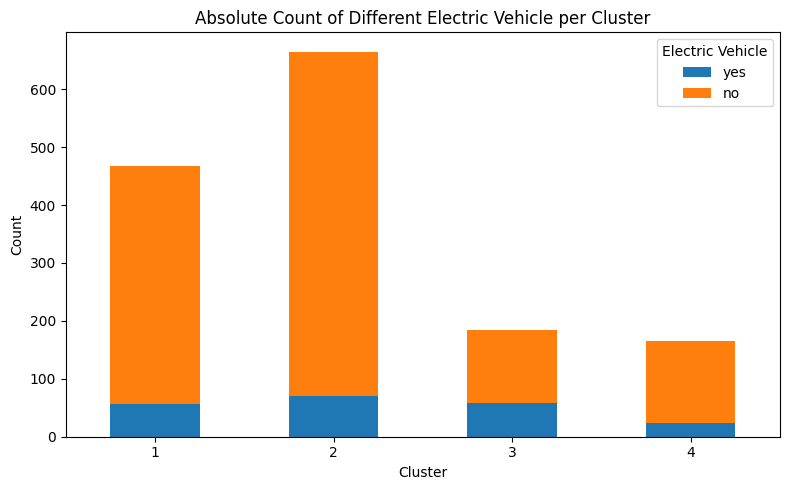

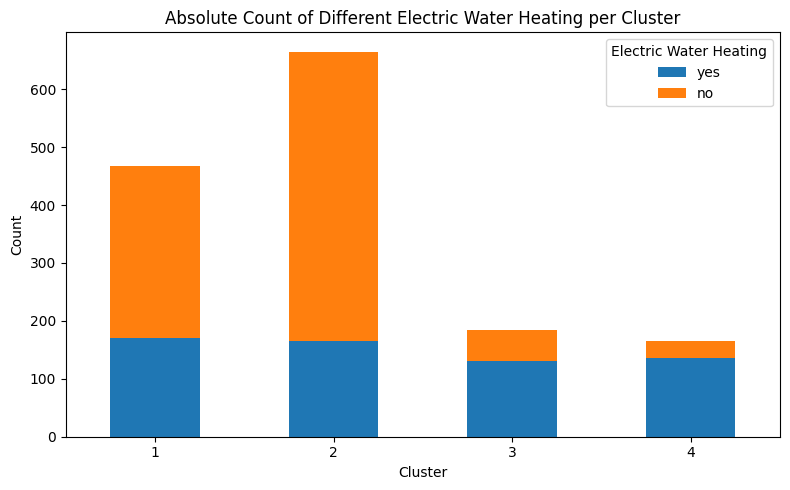

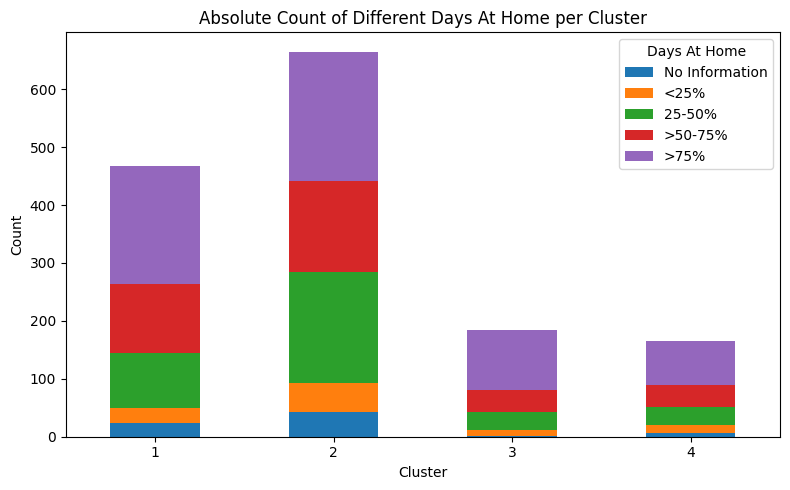

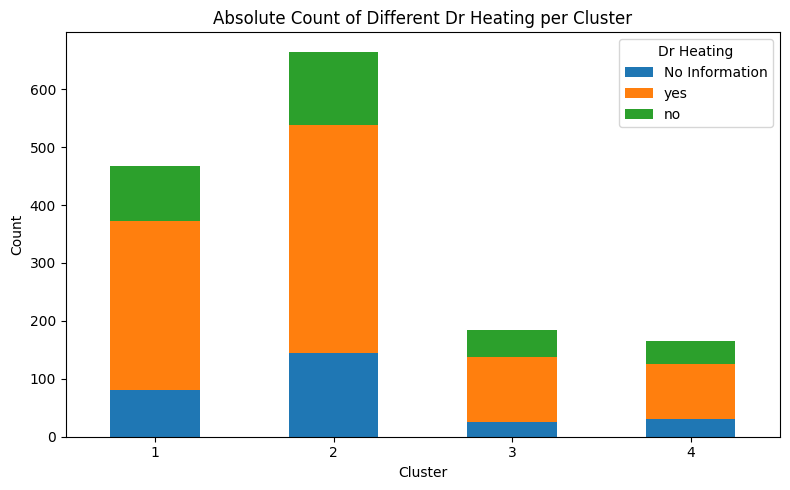

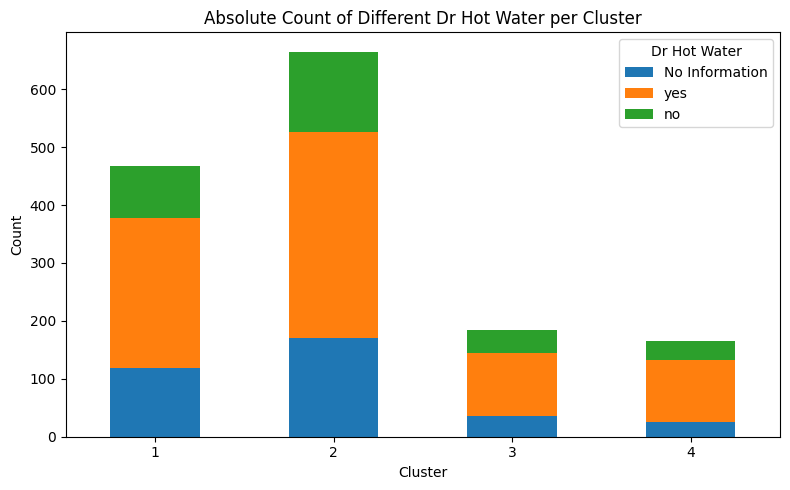

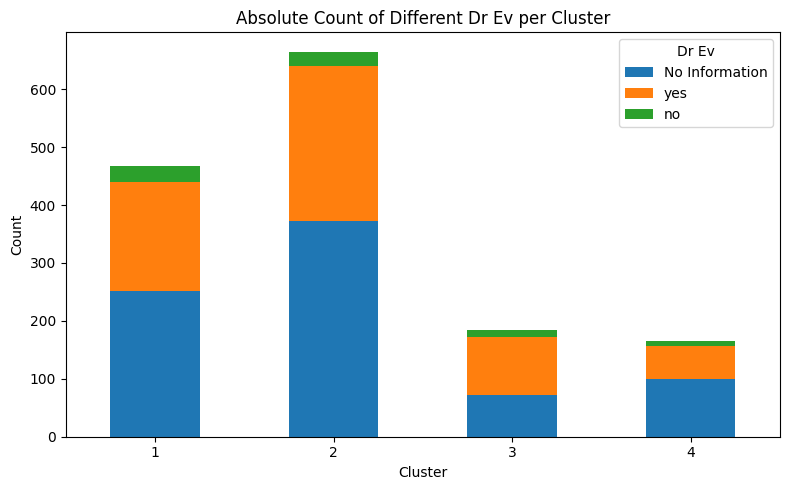

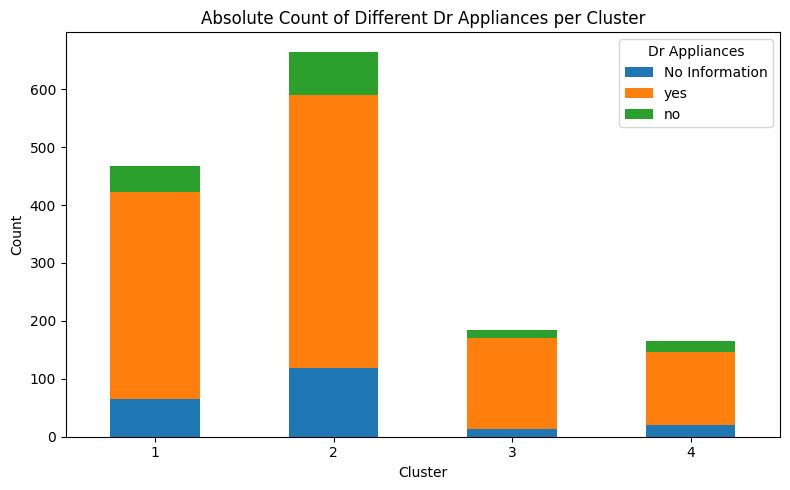

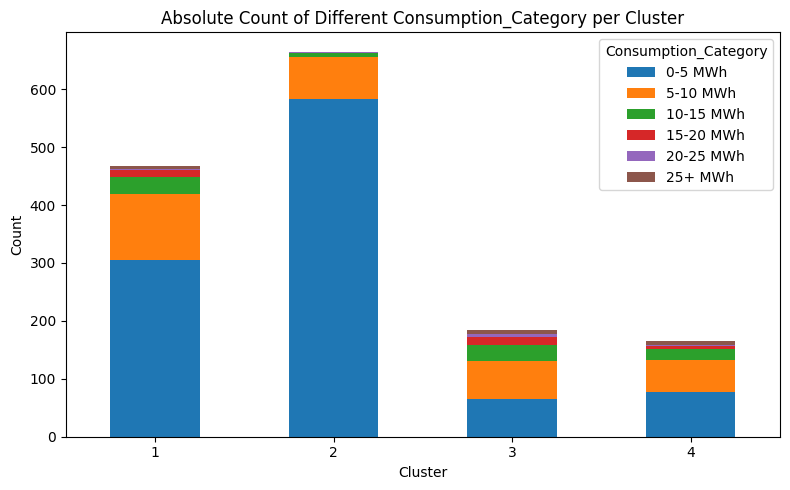

In [35]:
result_folder = Path(f'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/Plots/{data_type}/absolute')
result_folder.mkdir(parents=True, exist_ok=True)

final_df_absolute = final_df.to_pandas()
clusters = sorted(final_df_absolute['cluster'].unique())

cols = final_df_absolute.columns[2:]
category_columns = [col for col in cols if col != 'cluster']

custom_category_orders = {
    'building type': ['No Information', 'Flat', 'House'],
    'solar panels': ['yes', 'no'],
    'electric vehicle': ['yes', 'no'],
    'electric water heating': ['yes', 'no'],
    'consumption_category': ['0-5 MWh', '5-10 MWh', '10-15 MWh', '15-20 MWh', '20-25 MWh', '25+ MWh'],
    'days at home': ['No Information','<25%', '25-50%', '>50-75%', '>75%'],
    'DR heating': ['No Information' , 'yes', 'no'],
    'DR hot water': ['No Information' , 'yes', 'no'],
    'DR EV': ['No Information' , 'yes', 'no'],
    'DR appliances': ['No Information' , 'yes', 'no']
}

for col in category_columns:
    final_df_absolute[col] = final_df_absolute[col].astype(str)
    unique_cats = set(final_df_absolute[col].unique())

    fixed_category_order = custom_category_orders.get(col)
    if fixed_category_order is None:
        fixed_category_order = sorted(unique_cats)

    counts = {cat: [] for cat in fixed_category_order}

    for cl in clusters:
        cluster_subset = final_df_absolute[final_df_absolute['cluster'] == cl]
        for cat in fixed_category_order:
            count_cat = sum(cluster_subset[col] == cat)
            # Use count_cat directly for absolute values (not relative)
            counts[cat].append(count_cat)

    count_df = pd.DataFrame(counts, index=clusters)

    ax = count_df.plot(kind='bar', stacked=True, figsize=(8, 5))
    ax.set_title(f"Absolute Count of Different {col.title()} per Cluster")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Count")
    ax.legend(title=col.title(), loc='upper right')
    plt.xticks(rotation=0)
    plt.tight_layout()
    

    filename = f'{data_type}_{col}_absolute.png'
    full_path = os.path.join(result_folder, filename)

    plt.savefig(full_path)
    plt.show()

,No Information,Flat,House
1,0.130621,0.535332,0.334047
2,0.168421,0.684211,0.147368
3,0.070652,0.157609,0.771739
4,0.109091,0.406061,0.484848


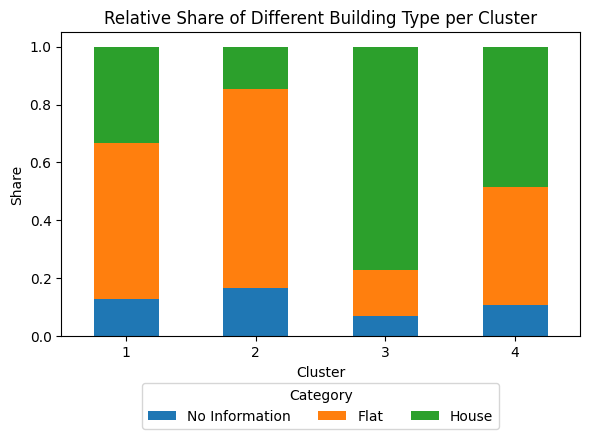

,yes,no
1,0.229122,0.770878
2,0.239098,0.760902
3,0.706522,0.293478
4,0.236364,0.763636


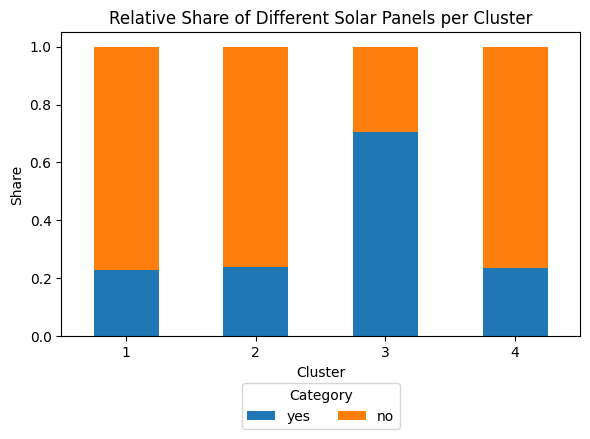

,yes,no
1,0.122056,0.877944
2,0.106767,0.893233
3,0.320652,0.679348
4,0.145455,0.854545


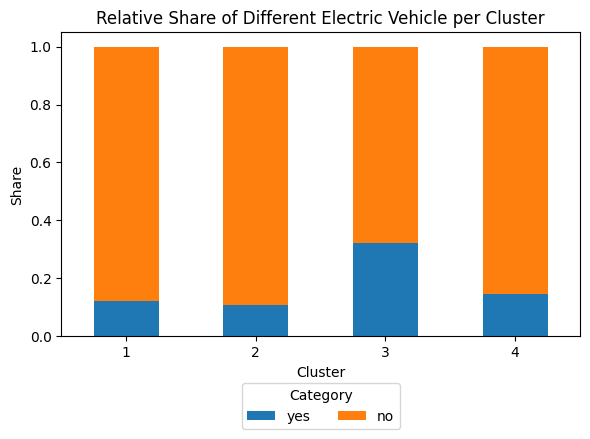

,yes,no
1,0.364026,0.635974
2,0.249624,0.750376
3,0.706522,0.293478
4,0.824242,0.175758


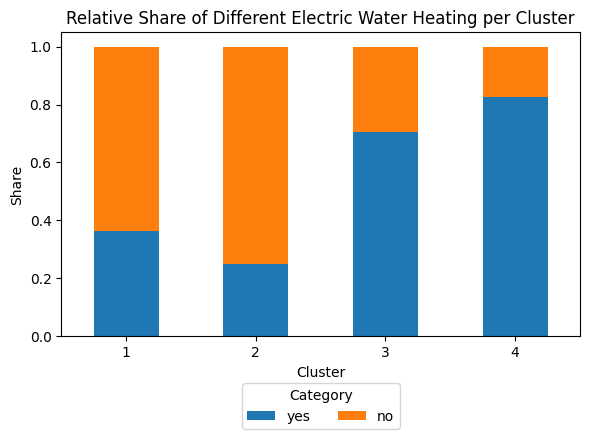

,No Information,<25%,25-50%,>50-75%,>75%
1,0.049251,0.057816,0.201285,0.254818,0.436831
2,0.063158,0.075188,0.290226,0.234586,0.336842
3,0.010870,0.054348,0.163043,0.206522,0.565217
4,0.036364,0.090909,0.181818,0.230303,0.460606


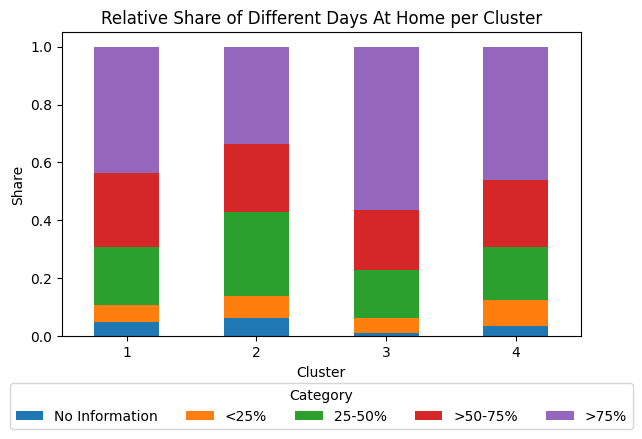

,No Information,yes,no
1,0.173448,0.625268,0.201285
2,0.218045,0.592481,0.189474
3,0.141304,0.603261,0.255435
4,0.187879,0.575758,0.236364


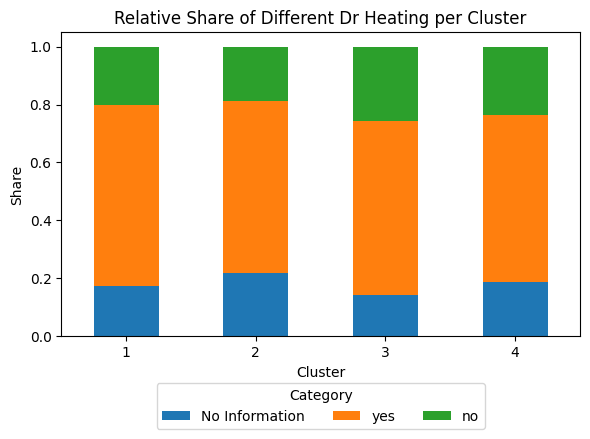

,No Information,yes,no
1,0.254818,0.554604,0.190578
2,0.255639,0.536842,0.207519
3,0.195652,0.586957,0.217391
4,0.151515,0.648485,0.200000


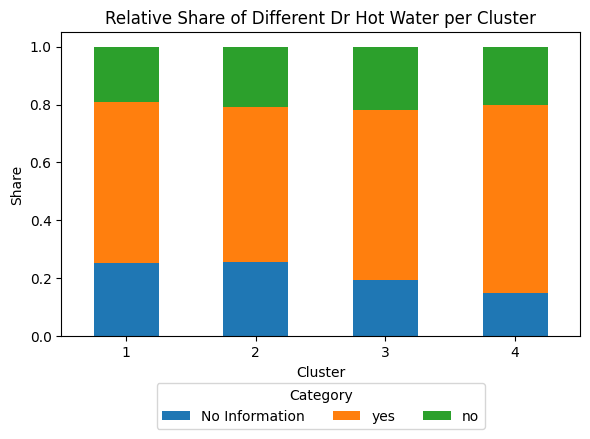

,No Information,yes,no
1,0.537473,0.402570,0.059957
2,0.560902,0.401504,0.037594
3,0.391304,0.548913,0.059783
4,0.606061,0.345455,0.048485


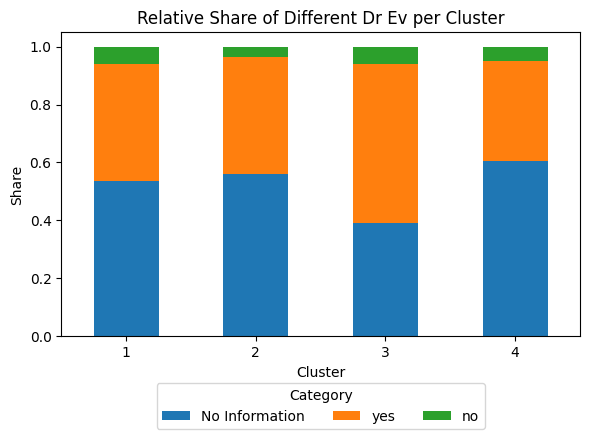

,No Information,yes,no
1,0.139186,0.764454,0.096360
2,0.177444,0.709774,0.112782
3,0.076087,0.853261,0.070652
4,0.127273,0.763636,0.109091


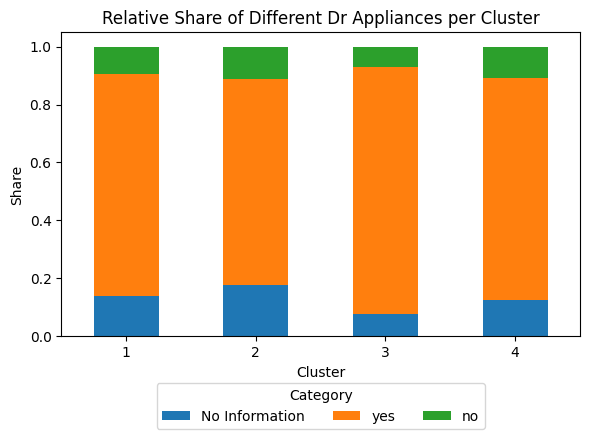

,0-5 MWh,5-10 MWh,10-15 MWh,15-20 MWh,20-25 MWh,25+ MWh
1,0.653105,0.244111,0.064240,0.023555,0.006424,0.008565
2,0.878195,0.106767,0.010526,0.001504,0.001504,0.001504
3,0.353261,0.358696,0.152174,0.076087,0.027174,0.032609
4,0.466667,0.333333,0.121212,0.024242,0.018182,0.036364


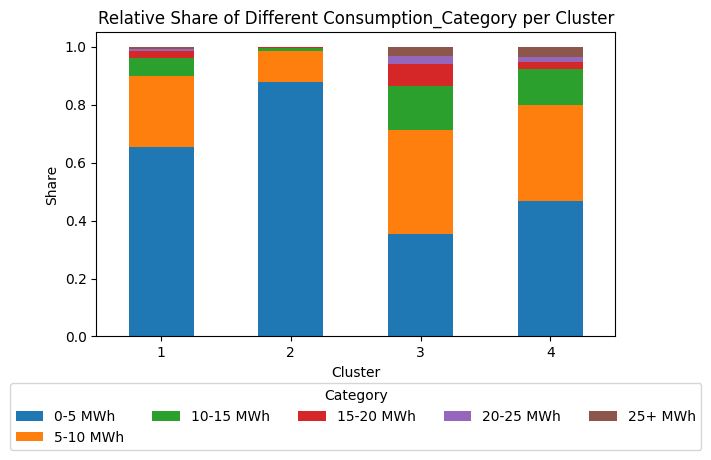

In [98]:
result_folder = Path(f'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/Plots/{data_type}/relative')
result_folder.mkdir(parents=True, exist_ok=True)
final_df_relative = final_df.to_pandas()
clusters = sorted(final_df_relative['cluster'].unique())

cols = final_df_relative.columns[2:]
category_columns = [col for col in cols if col != 'cluster']

for col in category_columns:
    final_df_relative[col] = final_df_relative[col].astype(str)
    unique_cats = set(final_df_relative[col].unique())
    fixed_category_order = custom_category_orders.get(col)
    if fixed_category_order is None:
        fixed_category_order = sorted(unique_cats)
    counts = {cat: [] for cat in fixed_category_order}
    for cl in clusters:
        cluster_subset = final_df_relative[final_df_relative['cluster'] == cl]
        total_in_cluster = len(cluster_subset)
        for cat in fixed_category_order:
            count_cat = sum(cluster_subset[col] == cat)
            prop_cat = count_cat / total_in_cluster if total_in_cluster > 0 else 0
            counts[cat].append(prop_cat)
    prop_df = pd.DataFrame(counts, index=clusters)
    display(prop_df)

    ax = prop_df.plot(kind='bar', stacked=True, figsize=(6, 4), width=0.5)
    ax.set_title(f"Relative Share of Different {col.title()} per Cluster")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Share")
    plt.xticks(rotation=0)
    plt.tight_layout()

    # Legend inside plot, upper right, slightly inside axes to avoid overlap
    ax.legend(title='Category', loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=5, fontsize='medium')
    
    filename = f'{data_type}_{col}_relative.png'
    full_path = result_folder / filename
    plt.savefig(full_path)
    plt.show()

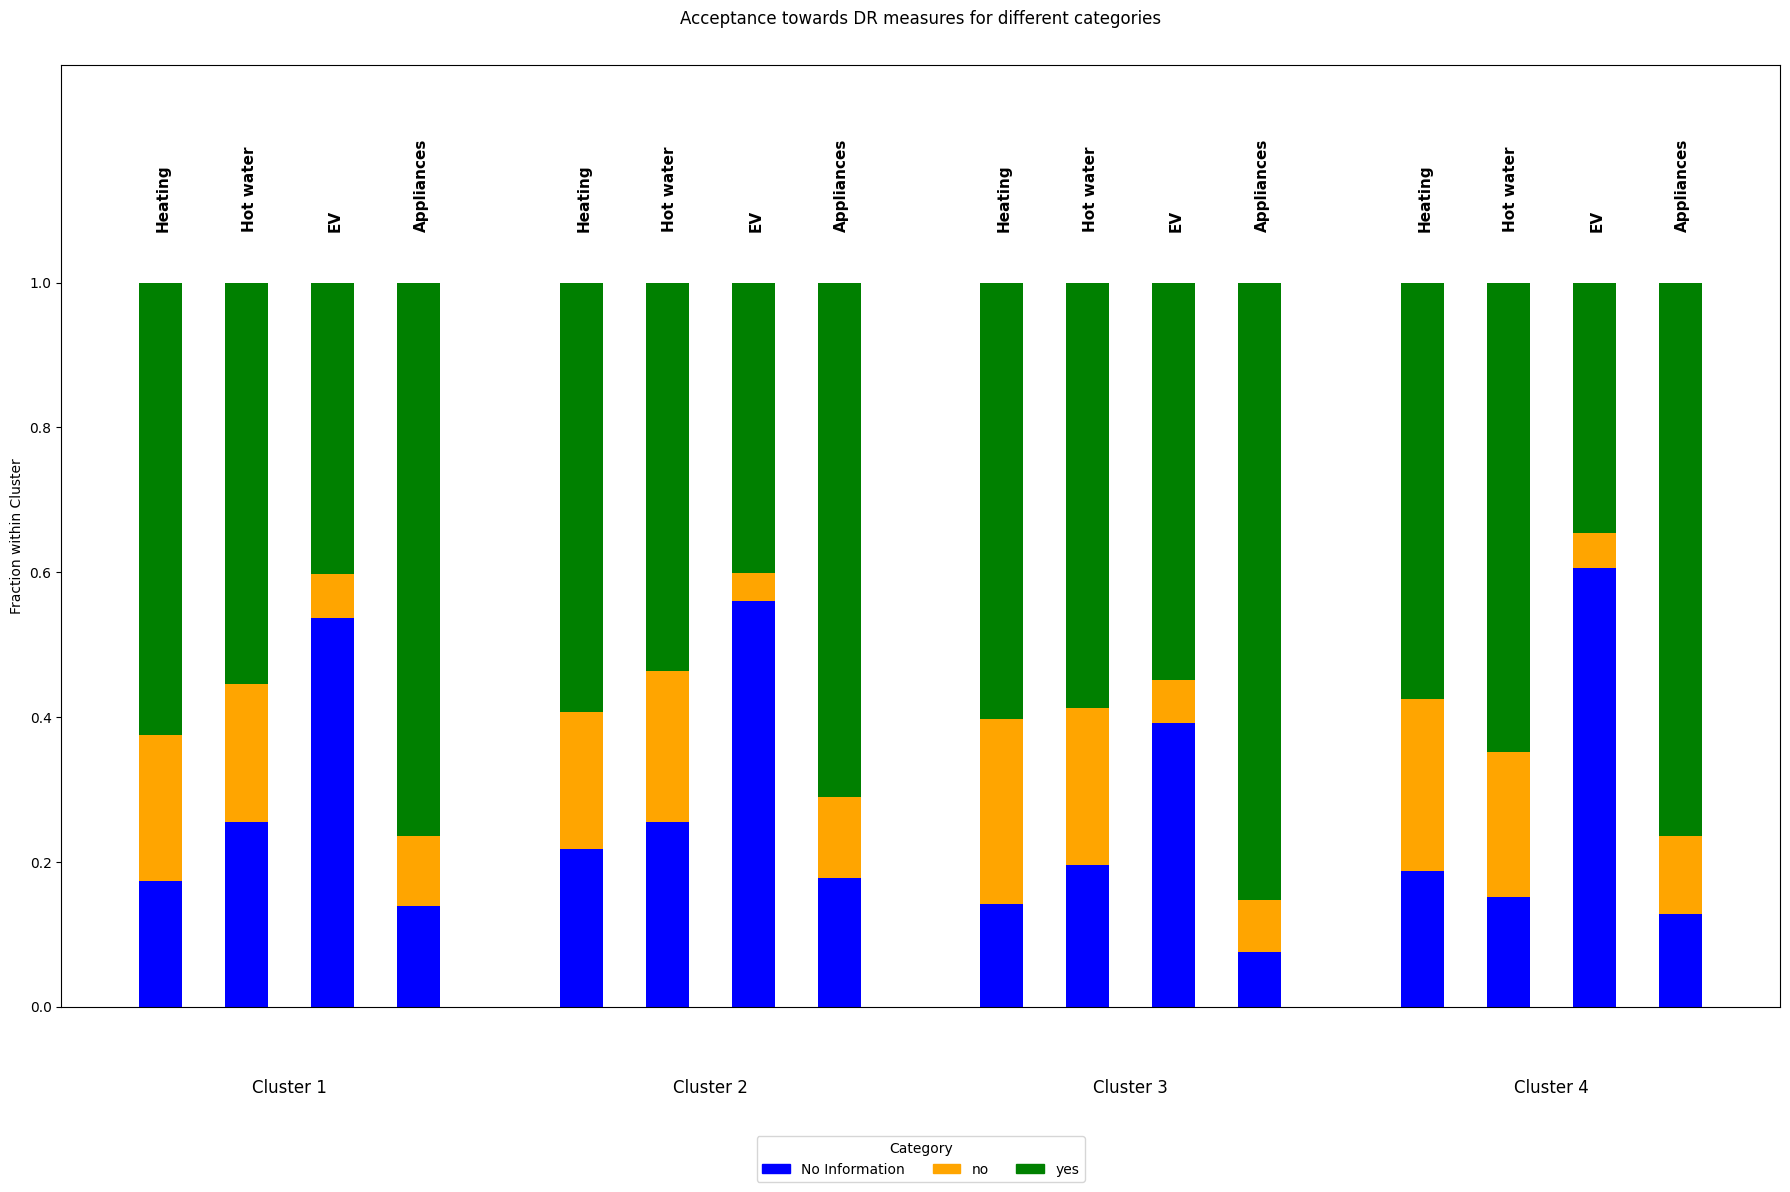

In [ ]:
# Define your variables (these must be set earlier in your script)
dr_columns = ['DR heating', 'DR hot water', 'DR EV', 'DR appliances']
dr_titles = ['Heating', 'Hot water', 'EV', 'Appliances']
dr_category_order = ['No Information', 'no', 'yes']
dr_category_colors = {'No Information': 'blue', 'no': 'orange', 'yes': 'green'}

n_clusters = len(clusters)
n_dr = len(dr_columns)
bar_width = 0.18
intra_cluster_gap = 0.18  # Space between DR bars within a cluster
x_gap = 0.50  # Space between clusters

group_width = n_dr * (bar_width + intra_cluster_gap) - intra_cluster_gap + x_gap
bar_data = np.zeros((n_clusters, n_dr, len(dr_category_order)))
for cluster_idx, cl in enumerate(clusters):
    cluster_subset = final_df_absolute[final_df_absolute['cluster'] == cl]
    for dr_idx, col in enumerate(dr_columns):
        total = len(cluster_subset[col])
        category_counts = [np.sum(cluster_subset[col] == cat) for cat in dr_category_order]
        fracs = [count / total if total > 0 else 0 for count in category_counts]
        bar_data[cluster_idx, dr_idx, :] = fracs

fig, ax = plt.subplots(figsize=(2 + n_clusters * n_dr * 1.0, 12))  # Make the plot tall and wide enough

# Calculate x positions for each DR bar within each cluster
bar_positions = []
for cluster in range(n_clusters):
    base_x = cluster * group_width
    for dr in range(n_dr):
        bar_x = base_x + dr * (bar_width + intra_cluster_gap)
        bar_positions.append(bar_x)

# Create the stacked bars
bottom = np.zeros(n_clusters * n_dr)
for cat_idx, cat in enumerate(dr_category_order):
    y_values = bar_data[:, :, cat_idx].flatten()
    bars = ax.bar(bar_positions, y_values, bottom=bottom, width=bar_width, color=dr_category_colors[cat],
                  label=cat if cat_idx == 0 else "")
    bottom += y_values

# Place vertical DR titles above each bar within cluster
for cluster in range(n_clusters):
    base_x = cluster * group_width
    for dr in range(n_dr):
        bar_x = base_x + dr * (bar_width + intra_cluster_gap) + bar_width / 2 -0.08
        ax.text(bar_x, 1.07, dr_titles[dr], ha='center', va='bottom', fontsize=11, fontweight='bold', rotation=90)
    group_center = base_x + ((n_dr * (bar_width + intra_cluster_gap) - intra_cluster_gap) / 2) - bar_width / 2
    ax.text(group_center, -0.1, f'Cluster {clusters[cluster]}', ha='center', va='top', fontsize=12)

ax.set_ylim(0, 1.3)  # y-axis goes only up to 1.15 (bars max out at 1, extra space for DR titles)
ax.set_yticks(np.arange(0, 1.01, 0.2))
ax.set_title("Acceptance towards DR measures for different categories", pad=30)  # Pad moves the title up
ax.set_ylabel("Fraction within Cluster")
ax.set_xticks([])  # No standard x-ticks—the cluster labels are custom

# Place the legend below the plot
handles = [plt.Rectangle((0,0),1,1, color=dr_category_colors[cat]) for cat in dr_category_order]
labels = dr_category_order
ax.legend(handles, labels, title='Category', loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=5, fontsize='medium')

plt.tight_layout()
plt.show()

In [33]:
# Assuming final_df_absolut contains the relevant columns: 'tenant type', 'age', 'bruttolastgang_kwh_sum'

tenant_type_order = [
    'Owner',
    'Tenant',
    'Living in a cooperative'
]

age_order = [
    '18-35 years old',
    '36 - 50 years old',
    '51 - 65 years old',
    'More than 65 years old'
]

for tenant_type in tenant_type_order:
    plot_df = final_df_absolute[
        (final_df_absolute['tenant type'] == tenant_type) &
        (final_df_absolute['age'].isin(age_order))
    ]
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=plot_df, x='age', y='bruttolastgang_kwh_sum', order=age_order)
    
    plt.title(f'Total Yearly Energy Consumption by Age Groups for Tenant Type: {tenant_type}', fontsize=14)
    plt.xlabel('Age Group', fontsize=12)
    plt.ylabel('Total Yearly Energy Consumption (kWh)', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

KeyError: 'tenant type'